<h3> Predicting Forest Fires in Algeria</h3>


Forest fires are a type of  uncontrolled and unwanted fire that usually have a negative impact. In 2007, forest fires in the Atlas Mountains, located on the northern coast of Algeria, killed several people as it spread rapidly due to hot, dry winds.In this project, we hope that we can predict forest fires when given weather conditions.


Our dataset contains weather information on the Sidi Bel Abbès and the Bejaia région, and includes information such as :
- `day`,`month`,`year`: the date of the instance
- `Temperature`: the maximum temperature in degrees celsius
- `RH` : Relative humidity in percentages
- `Ws` : wind speed in kilometers per hour
- `Rain`: total amount of rain, in mm
- `Classes` : whether or not there was fire


The data set also includes indexes:
- `FFMC`: Fine Fuel Moisture Code
- `DMC` : Dull Moisture Code
- `DC`: Drought Code 
- `ISI`: Initial Spread Index
- `BUI`: Buildup Index
- `FWI`: Fire Weather Index

For more information on FWI, you can look at [this website](https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi).

first, we load the necessary libraries:

In [200]:
library(tidyverse)
library(repr)
library(GGally)
library(tidymodels)

options(repr.matrix.max.rows = 6)

set.seed(123)

After inspecting the dataset, we copy and paste the data set's url from 
[this website](https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++) and load it to our notebook.

The dataset has one table for each region, so we make 2 datasets:

In [201]:
fire_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv"
# this takes the bajaja region
forest_fire_bejaia <- read_csv(fire_url, skip = 1, n_max = 122)
# this takes the sidi region
forest_fire_sidi <- read_csv(fire_url, skip = 126)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_character(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“1 parsing failure.
row col   expected     actual                                                                                                       file
 44  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-lear

Then, we fix the error on the 44th row on `forest_fire_sidi`.

In [202]:
forest_fire_sidi[44, 10] <- "14.6"
forest_fire_sidi[44, 11] <- 9
forest_fire_sidi[44, 12] <- 12.5
forest_fire_sidi[44, 13] <- "10.4"
forest_fire_sidi[44, 14] <- "fire"

Now, we change the column's data types and combine both datasets together.

In [203]:
forest_fire_sidi <-  forest_fire_sidi %>%
    mutate(DC = as.numeric(DC)) %>%
    mutate(FWI = as.numeric(FWI))

forest_fires <- rbind(forest_fire_sidi, forest_fire_bejaia)

We also need to change  `Classes`  into a factor because it's the one we want to predict.

In [193]:
forest_fires <- forest_fires %>%
    mutate(Classes = as_factor(Classes))

forest_fires

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
01,06,2012,32,71,12,0.7,57.1,2.5,8.2,0.6,2.8,0.2,not fire
02,06,2012,30,73,13,4.0,55.7,2.7,7.8,0.6,2.9,0.2,not fire
03,06,2012,29,80,14,2.0,48.7,2.2,7.6,0.3,2.6,0.1,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,09,2012,32,47,14,0.7,77.5,7.1,8.8,1.8,6.8,0.9,not fire
29,09,2012,26,80,16,1.8,47.4,2.9,7.7,0.3,3.0,0.1,not fire
30,09,2012,25,78,14,1.4,45.0,1.9,7.5,0.2,2.4,0.1,not fire


Now, we split our data into the training and test data sets:

In [198]:
#We don't want the date columns: our explanation will be given later!
forest_fires <- forest_fires %>%
    select(Temperature:Classes)

fire_split <- initial_split(forest_fires, prop = 0.75, strata = Classes)
fire_train <- training(fire_split)
fire_test <- testing(fire_split)

We can see the min/max and average of  the numeric columns with `map_df`.

In [204]:
forest_fire_training_range <- fire_train %>%
    select(Temperature:FWI) %>%
    map_df(range)

forest_fire_training_mean <- fire_train %>%
    select(Temperature:FWI) %>%
    map_df(mean)

forest_fire_training_range
forest_fire_training_mean

Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
24,21,6,0.0,28.6,0.9,6.9,0.0,1.4,0.0
40,90,29,16.8,94.3,65.9,220.4,17.2,68.0,31.1


Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
32.34783,61.58696,15.38587,0.6673913,78.47717,15.18098,51.98098,4.767935,17.34891,7.263587


But what do these numbers actually mean?  It's easier to process visual information, so  we want to draw plots that compare the columns.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



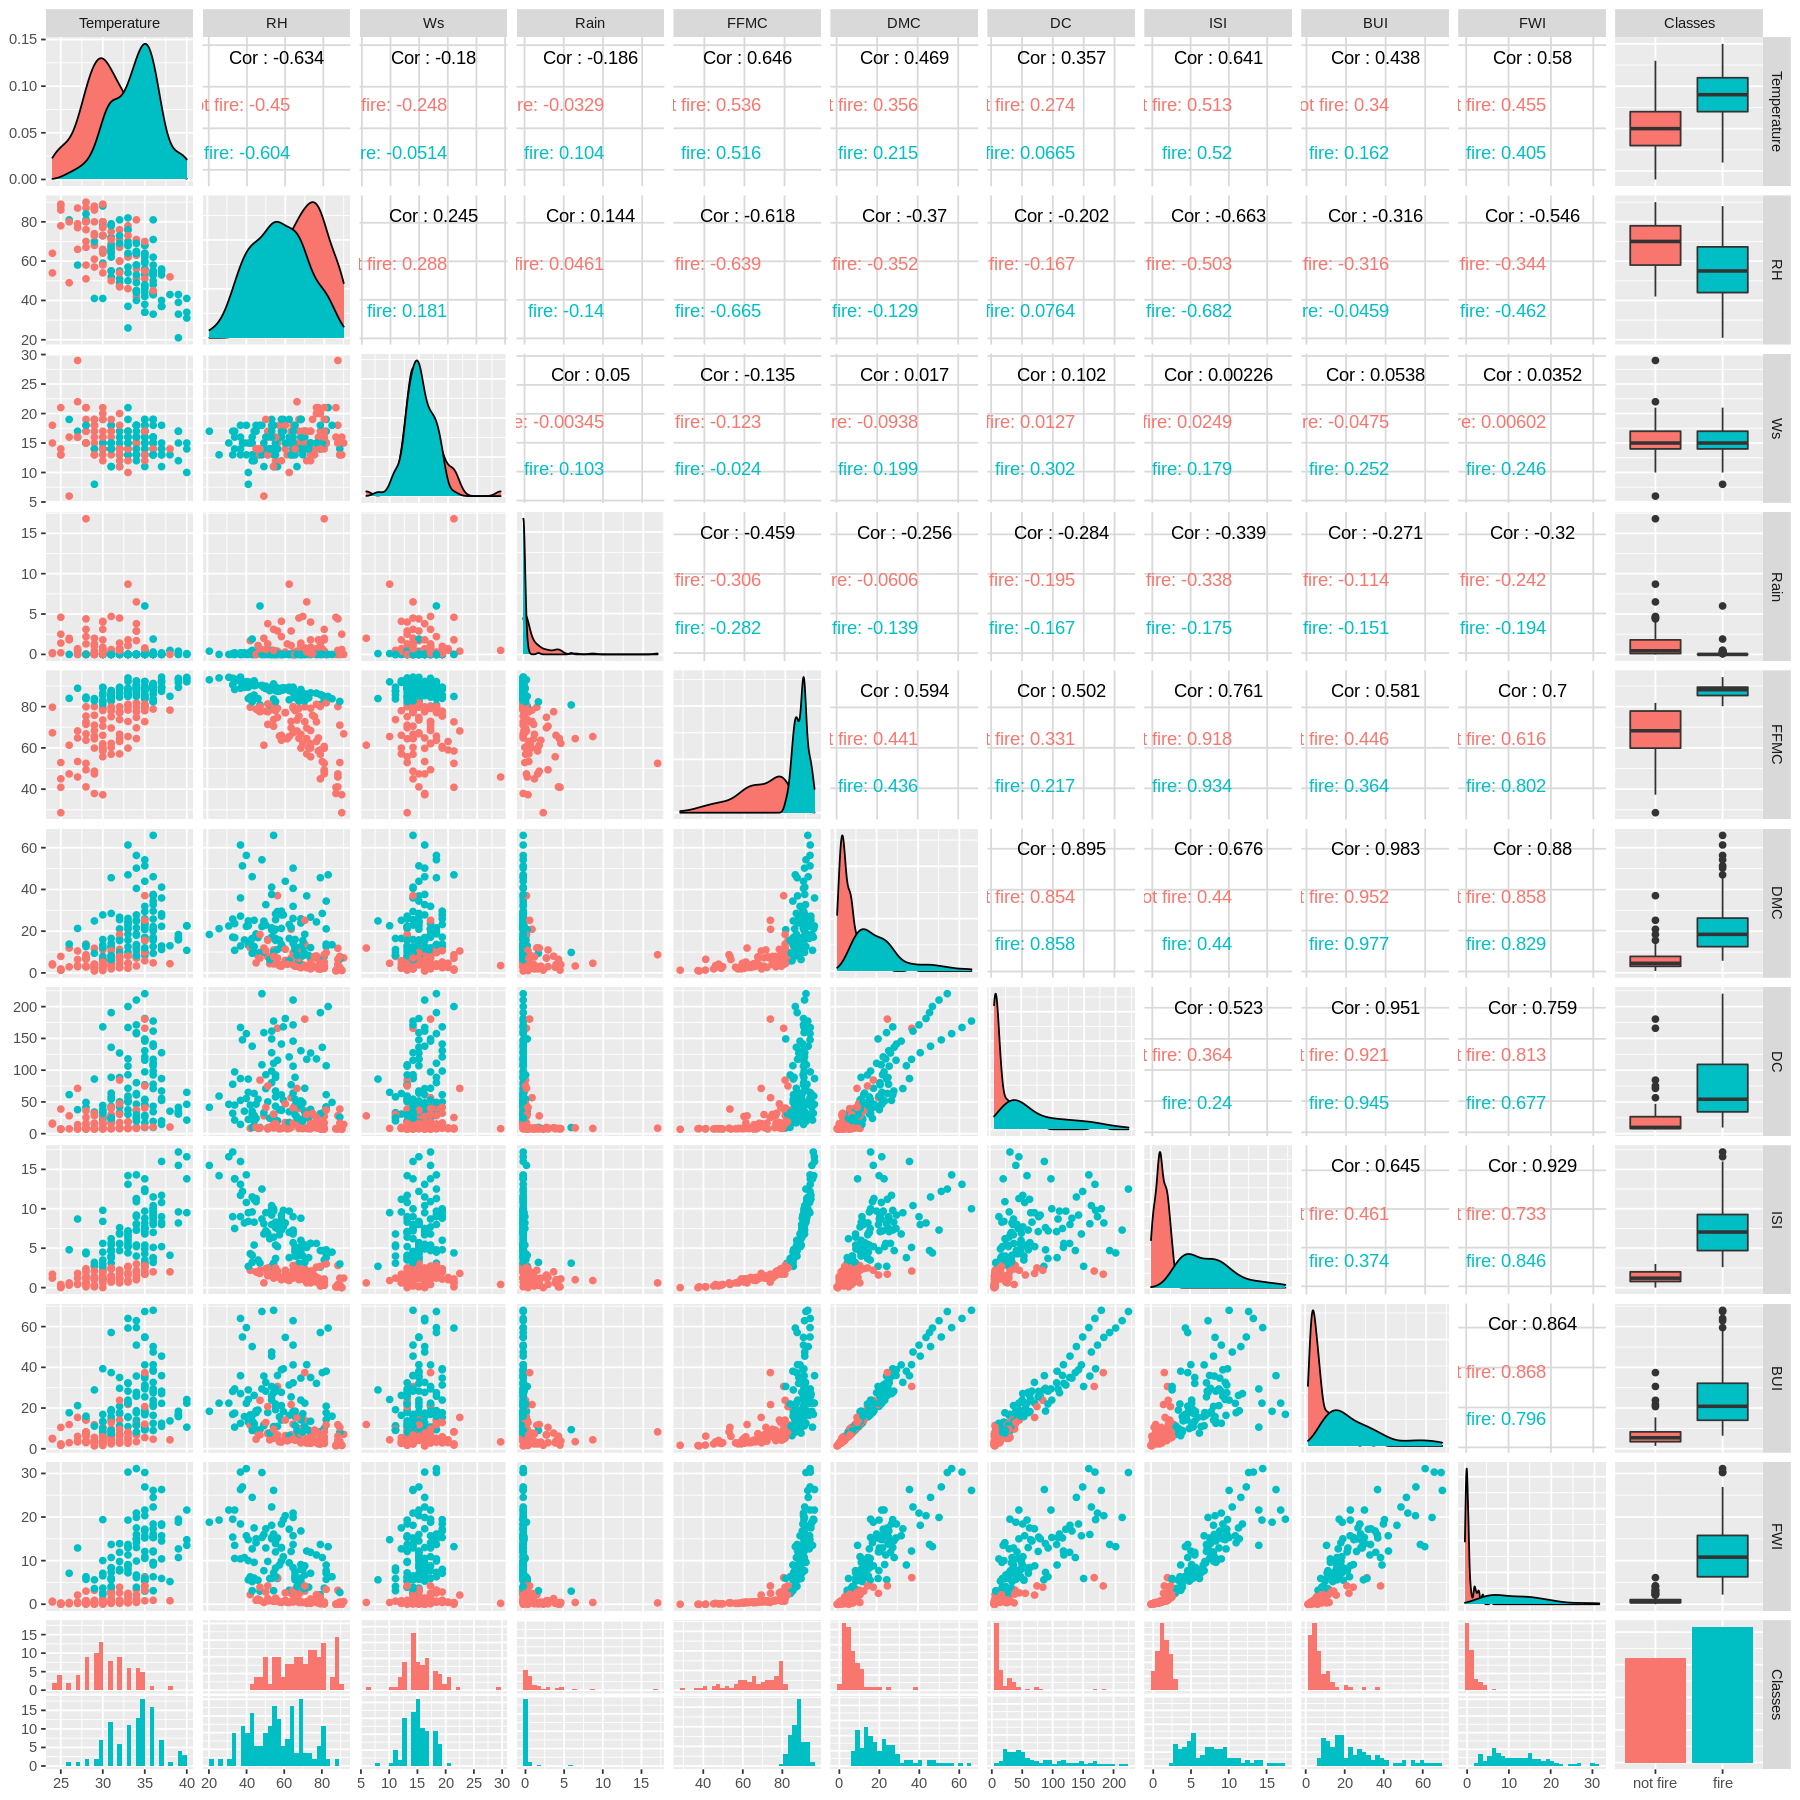

In [205]:
options(repr.plot.width=20, repr.plot.height=20)
fire_train %>% 
    ggpairs(aes(color = Classes))

To make a model that predicts the `Classes` column, we need to choose a few columns as the predictors and decide on a k value for our k nearest neighbour(s).

Since all of this occured in 2012 we decided not to use `day`, `month` and `year`. The  index columns (FFMC:FWI) are calculated based on temperature, relative humidity, wind and rain. `ISI` is calculated from Ws and FFMC, and `BUI` is calculated from DMC and DC. These 2 columns encompass information from other columns, so we use them to predict `Classes`. 

We can visualise our results using a scatter plot that shows the `ISI` and `BUI` values on the axes, and color-coded based on the `Classes`.

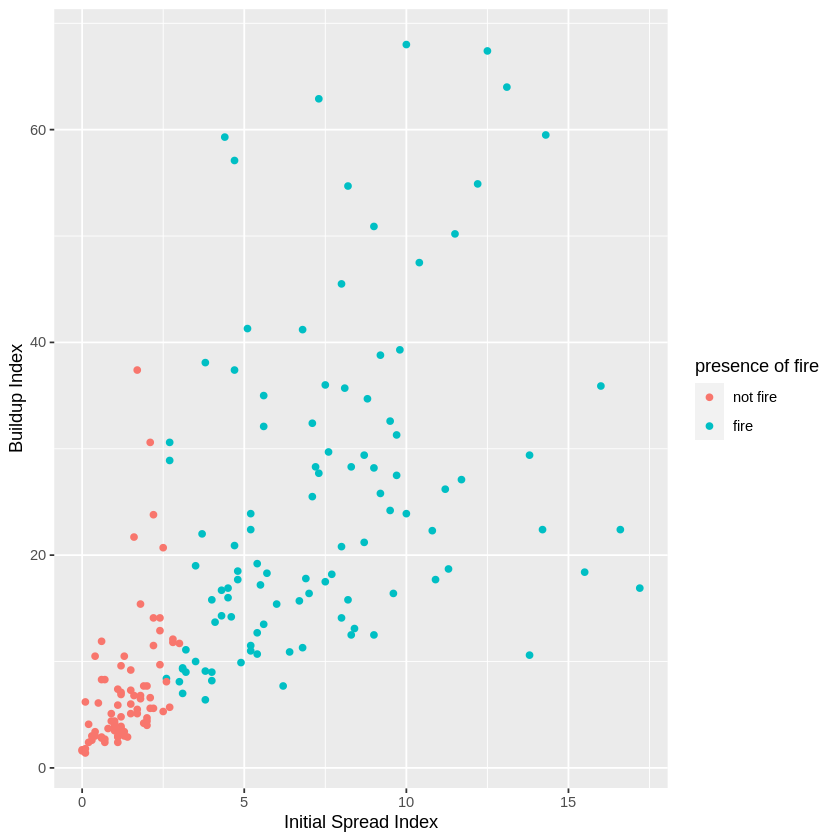

In [217]:
options(repr.plot.width=7, repr.plot.height=7)
ggplot(fire_train, aes(x = ISI, y = BUI, color = Classes)) +
    geom_point() +
    labs(x = "Initial Spread Index", y = "Buildup Index", color = "presence of fire")

We used cross validation on `fire_train` and decided on $k$ = 2

In [207]:
fire_vfold <- vfold_cv(fire_train, v = 5, strata = Classes)

fire_recipe <- recipe(Classes ~ ISI + BUI, data = fire_train)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_results <- workflow() %>%
  add_recipe(fire_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = fire_vfold, grid = 10) %>%
  collect_metrics()

accuracies <- knn_results %>%
  filter(.metric == "accuracy")

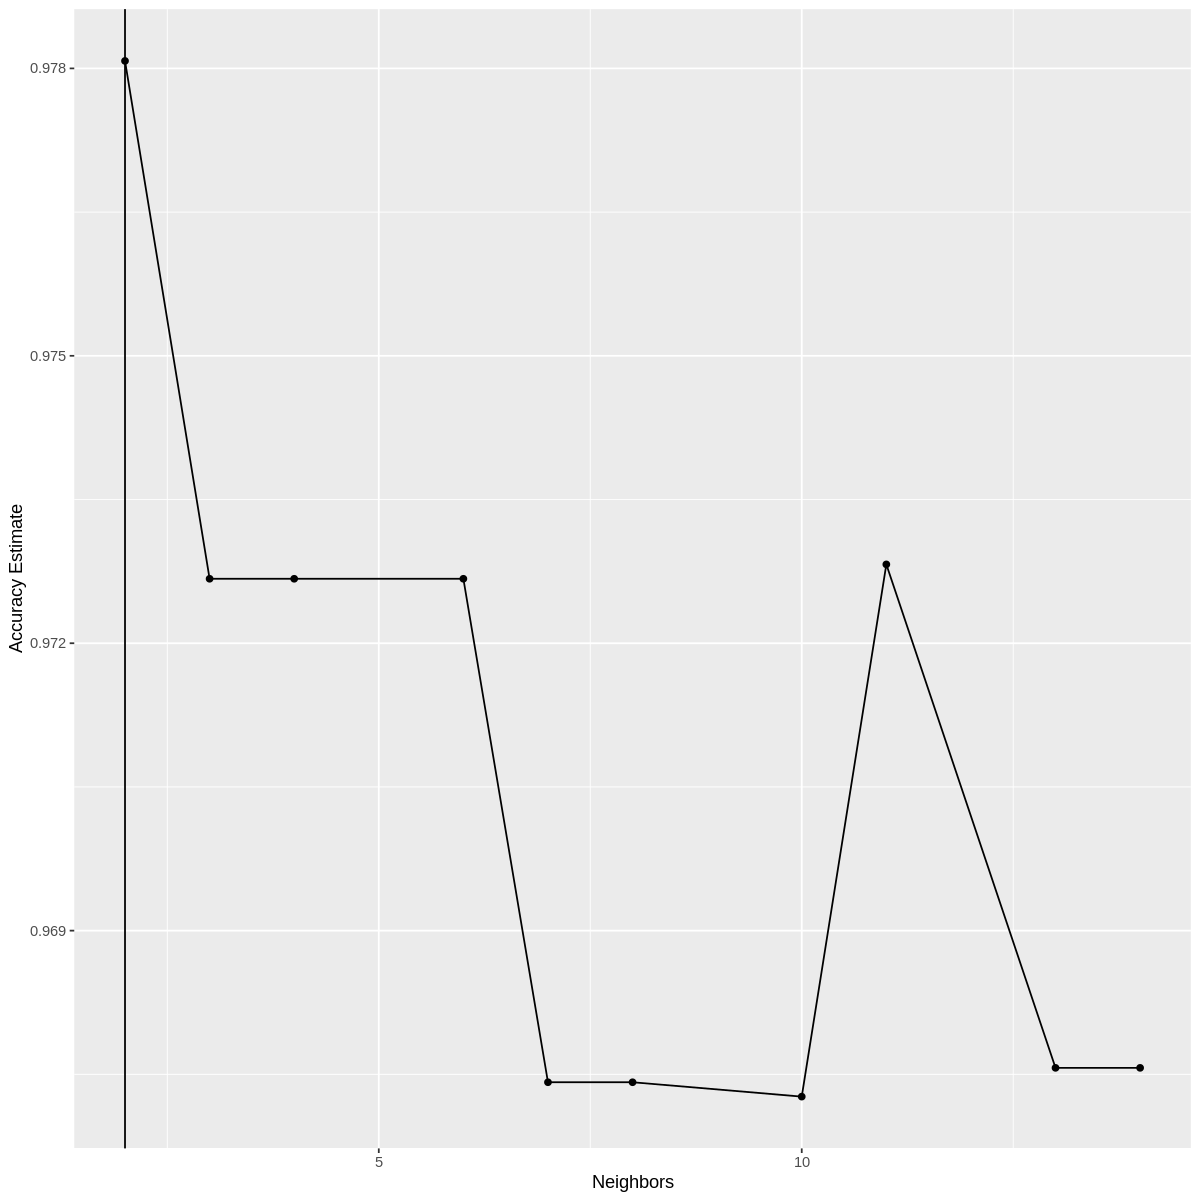

In [216]:
options(repr.plot.width=10, repr.plot.height=10)
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  geom_vline(xintercept = 2)+
  labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_vs_k

**Expected outcomes and significance:**

 We hope that in the future, something like this can be used to predict real fires. Predicting fire will  be beneficial because it means we can mobilise firefighters faster, which helps stop the spread of fires. Hopefully, this can also lead to other questions, such as predicting the magnitude of a fire.
